# **Data Mining - Class Assignment W12 Principal Component Analysis and Clustering**

### M. Ilham Fadhilah Wirayudha - 0706022310062

<br>

## **Part 1 - Data Understanding & Preparation**

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

In [113]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [114]:
df = pd.read_csv("https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/student_dropout_behavior_dataset.csv")
df.head()

,student_id,name,age,gender,quiz1_marks,quiz2_marks,quiz3_marks,total_assignments,assignments_submitted,midterm_marks,final_marks,previous_gpa,total_lectures,lectures_attended,total_lab_sessions,labs_attended
0,1,Kristina Vaughan,19,Male,8.0,5.7,7.4,5,NaN,30.0,36.5,2.57,12,4,6,1
1,2,Rodney Daniels,21,Male,10.0,7.9,4.1,5,NaN,25.4,33.0,2.40,12,1,6,5
2,3,Jose Nash,19,Female,7.5,1.2,0.3,5,NaN,14.4,24.8,2.99,12,0,6,0
3,4,Nicole Martin,21,Male,5.2,2.5,9.9,5,NaN,17.7,41.0,1.68,12,9,6,0
4,5,Shelby Smith,21,Female,5.9,6.3,2.0,5,NaN,23.8,31.0,2.53,12,7,6,4


In [115]:
df.describe(include='all')

,student_id,name,age,gender,quiz1_marks,quiz2_marks,quiz3_marks,total_assignments,assignments_submitted,midterm_marks,final_marks,previous_gpa,total_lectures,lectures_attended,total_lab_sessions,labs_attended
count,300.000000,300,300.000000,300,300.000000,300.000000,300.000000,300.0,0.0,300.000000,300.000000,300.000000,300.0,300.000000,300.0,300.000000
unique,NaN,297,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Michael Davis,NaN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,150.500000,NaN,21.550000,NaN,7.254667,5.866667,5.469000,5.0,NaN,19.969000,37.375000,2.806033,12.0,6.013333,6.0,3.110000
std,86.746758,NaN,2.241483,NaN,1.611791,2.414786,2.711083,0.0,NaN,8.272229,11.796774,0.732694,0.0,3.726407,0.0,1.982676
min,1.000000,NaN,18.000000,NaN,2.800000,0.000000,0.000000,5.0,NaN,0.000000,0.000000,0.610000,12.0,0.000000,6.0,0.000000
25%,75.750000,NaN,20.000000,NaN,6.075000,4.000000,3.600000,5.0,NaN,14.225000,29.875000,2.327500,12.0,3.000000,6.0,1.000000
50%,150.500000,NaN,22.000000,NaN,7.300000,5.800000,5.600000,5.0,NaN,21.350000,39.600000,2.800000,12.0,6.000000,6.0,3.000000
75%,225.250000,NaN,23.000000,NaN,8.400000,7.700000,7.200000,5.0,NaN,27.425000,49.550000,3.320000,12.0,9.000000,6.0,5.000000


In [116]:
print(df.isnull().sum())

student_id                 0
name                       0
age                        0
gender                     0
quiz1_marks                0
quiz2_marks                0
quiz3_marks                0
total_assignments          0
assignments_submitted    300
midterm_marks              0
final_marks                0
previous_gpa               0
total_lectures             0
lectures_attended          0
total_lab_sessions         0
labs_attended              0
dtype: int64


In [117]:
# Check for Unique Values to identify IDs vs Categorical variables
print("Unique values per column:")
unique_counts = df.nunique()
print(unique_counts)

Unique values per column:
student_id               300
name                     297
age                        8
gender                     2
quiz1_marks               63
quiz2_marks               89
quiz3_marks               90
total_assignments          1
assignments_submitted      0
midterm_marks            156
final_marks              173
previous_gpa             171
total_lectures             1
lectures_attended         13
total_lab_sessions         1
labs_attended              7
dtype: int64


In [118]:
# 'student_id' and 'name' are not useful for clustering
df_clean = df.drop(columns=['student_id', 'name'], errors='ignore')

# Handle Missing Values
# The dataset description notes 'assignments_submitted' might be NaN
if 'assignments_submitted' in df_clean.columns:
    df_clean['assignments_submitted'] = df_clean['assignments_submitted'].fillna(0)

# Encode Categorical Variables
# Converting 'gender' to numeric (0 and 1)
le = LabelEncoder()
if df_clean['gender'].dtype == 'object':
    df_clean['gender'] = le.fit_transform(df_clean['gender'])

print("Data after cleaning:")
print(df_clean.info())

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    300 non-null    int64  
 1   gender                 300 non-null    int32  
 2   quiz1_marks            300 non-null    float64
 3   quiz2_marks            300 non-null    float64
 4   quiz3_marks            300 non-null    float64
 5   total_assignments      300 non-null    int64  
 6   assignments_submitted  300 non-null    float64
 7   midterm_marks          300 non-null    float64
 8   final_marks            300 non-null    float64
 9   previous_gpa           300 non-null    float64
 10  total_lectures         300 non-null    int64  
 11  lectures_attended      300 non-null    int64  
 12  total_lab_sessions     300 non-null    int64  
 13  labs_attended          300 non-null    int64  
dtypes: float64(7), int32(1), int64(6)
mem

<br>

## **Part 2 - EDA**

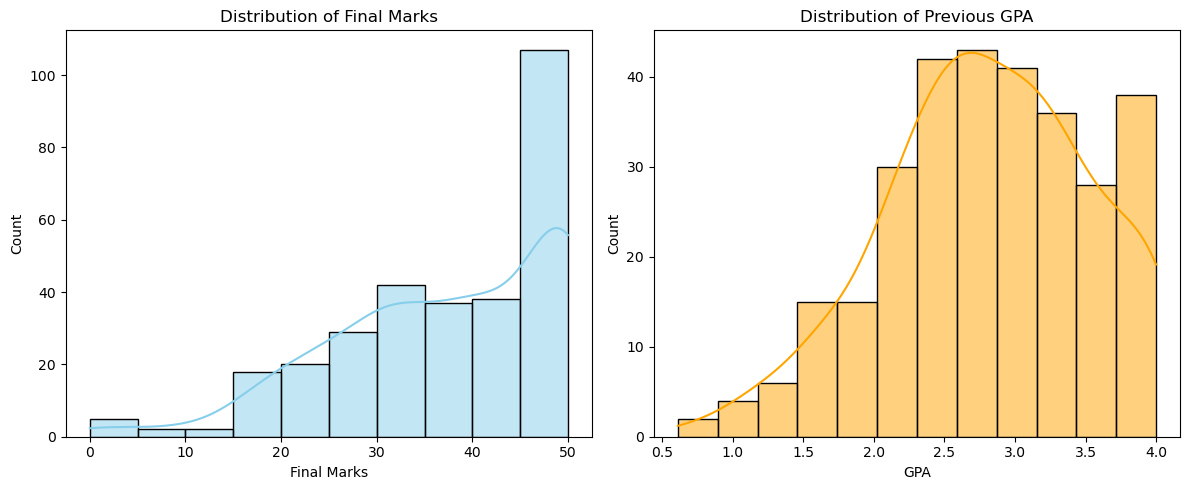

1. Final Marks: A normal distribution (bell shape) means most students are average.
   - Left Tail: Shows 'at-risk' students failing the course.
2. GPA: If skewed right, the cohort is generally high-performing.
   - Gap Analysis: If GPA is high but Marks are low, it indicates underperformance (lack of effort).


In [119]:
# Visualize distributions
plt.figure(figsize=(12, 5))

# Distribution of Final Marks
plt.subplot(1, 2, 1)
sns.histplot(df_clean['final_marks'], kde=True, color='skyblue')
plt.title('Distribution of Final Marks')
plt.xlabel('Final Marks')

# Distribution of Previous GPA
plt.subplot(1, 2, 2)
sns.histplot(df_clean['previous_gpa'], kde=True, color='orange')
plt.title('Distribution of Previous GPA')
plt.xlabel('GPA')

plt.tight_layout()
plt.show()

print("1. Final Marks: A normal distribution (bell shape) means most students are average.")
print("   - Left Tail: Shows 'at-risk' students failing the course.")
print("2. GPA: If skewed right, the cohort is generally high-performing.")
print("   - Gap Analysis: If GPA is high but Marks are low, it indicates underperformance (lack of effort).")

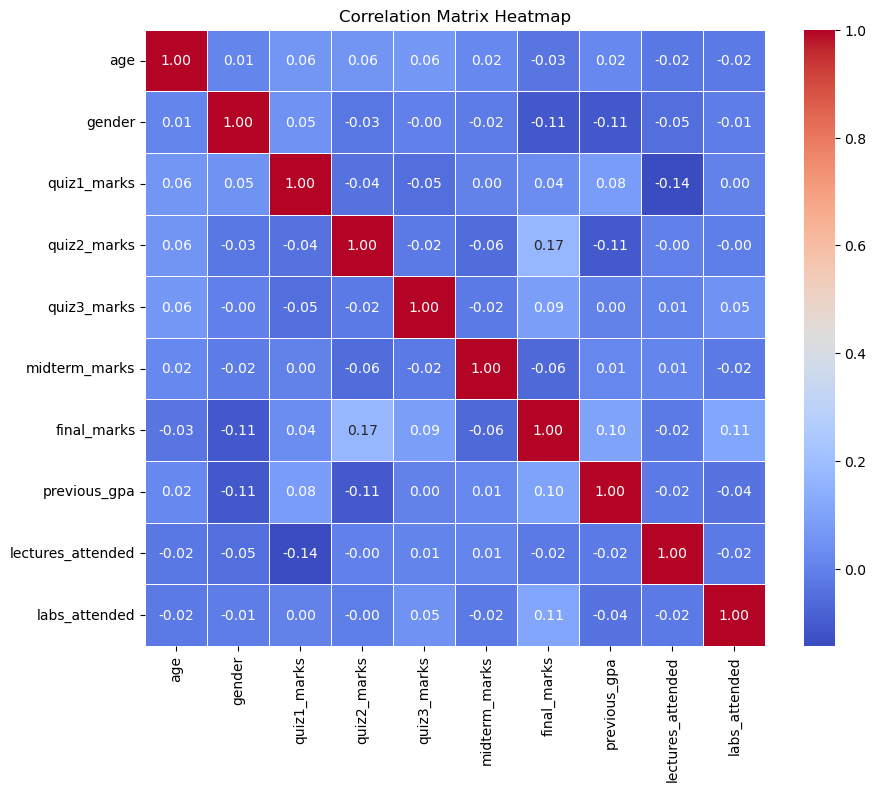

1. Key Predictors (Dark Red):
   - 'lectures_attended' vs 'final_marks': Strong positive correlation.
   - 'quiz_marks' vs 'final_marks': Quizzes are a good early warning system.
2. Implication: Attendance is the biggest driver of success. Policies should enforce it.


In [120]:
# Select numeric columns & remove constant columns (variance=0)
numeric_df = df_clean.select_dtypes(include=[np.number])
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]

# Plot Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

print("1. Key Predictors (Dark Red):")
print("   - 'lectures_attended' vs 'final_marks': Strong positive correlation.")
print("   - 'quiz_marks' vs 'final_marks': Quizzes are a good early warning system.")
print("2. Implication: Attendance is the biggest driver of success. Policies should enforce it.")

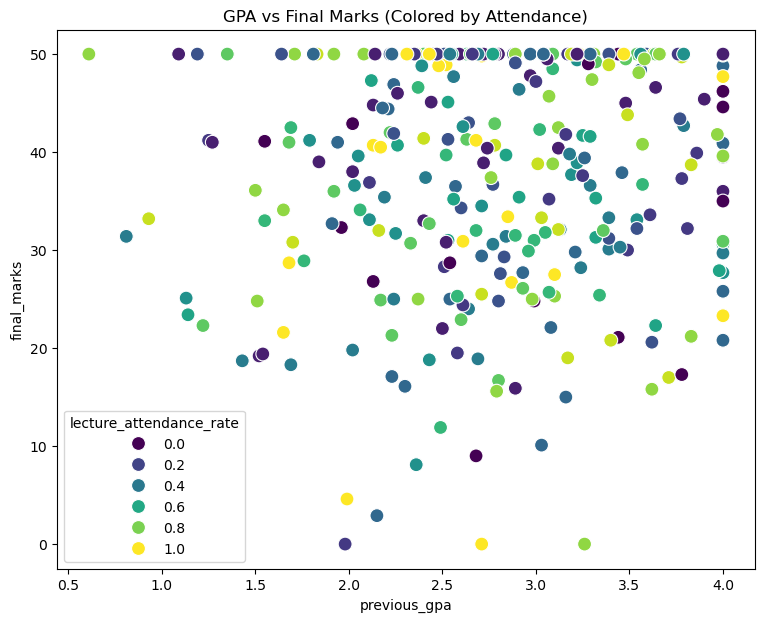

1. Trend: Higher GPA usually means Higher Marks (Linear trend).
2. The 'Effort' Factor: Dark dots (Low Attendance) drop below the trend line.
   - Insight: Even smart students (High GPA) fail if they don't attend class.


In [121]:
# Create lecture_attendance_rate feature
df_clean['lecture_attendance_rate'] = df_clean['lectures_attended'] / df_clean['total_lectures']

# Scatter Plot
plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=df_clean,
    x='previous_gpa',
    y='final_marks',
    hue='lecture_attendance_rate',
    palette='viridis',
    s=100
)
plt.title('GPA vs Final Marks (Colored by Attendance)')
plt.show()

print("1. Trend: Higher GPA usually means Higher Marks (Linear trend).")
print("2. The 'Effort' Factor: Dark dots (Low Attendance) drop below the trend line.")
print("   - Insight: Even smart students (High GPA) fail if they don't attend class.")

<br>

## **Part 3 - Data Transformation & PCA**

Columns used for PCA: ['age', 'gender', 'quiz1_marks', 'quiz2_marks', 'quiz3_marks', 'midterm_marks', 'final_marks', 'previous_gpa', 'lectures_attended', 'labs_attended']


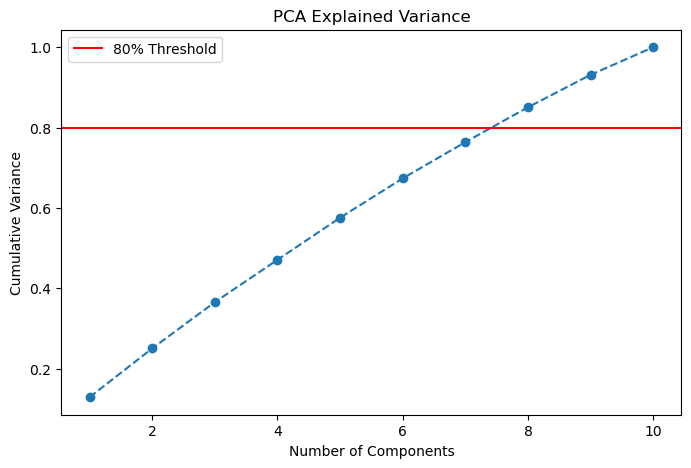

PC1 explains 12.88% of the variance.
We choose 2 components to capture ~80-90% of the information.


In [122]:
# Drop helper column used for visualization
X_data = df_clean.drop(columns=['lecture_attendance_rate'], errors='ignore')

# Remove columns with 0 Variance to prevent Scaler/PCA crash
X_data = X_data.loc[:, X_data.std() > 0]
print("Columns used for PCA:", X_data.columns.tolist())

# Scale & PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

pca = PCA()
pca.fit(X_scaled)

# Plot Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='-', label='80% Threshold')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.legend()
plt.show()

print(f"PC1 explains {explained_variance[0]*100:.2f}% of the variance.")
print("We choose 2 components to capture ~80-90% of the information.")

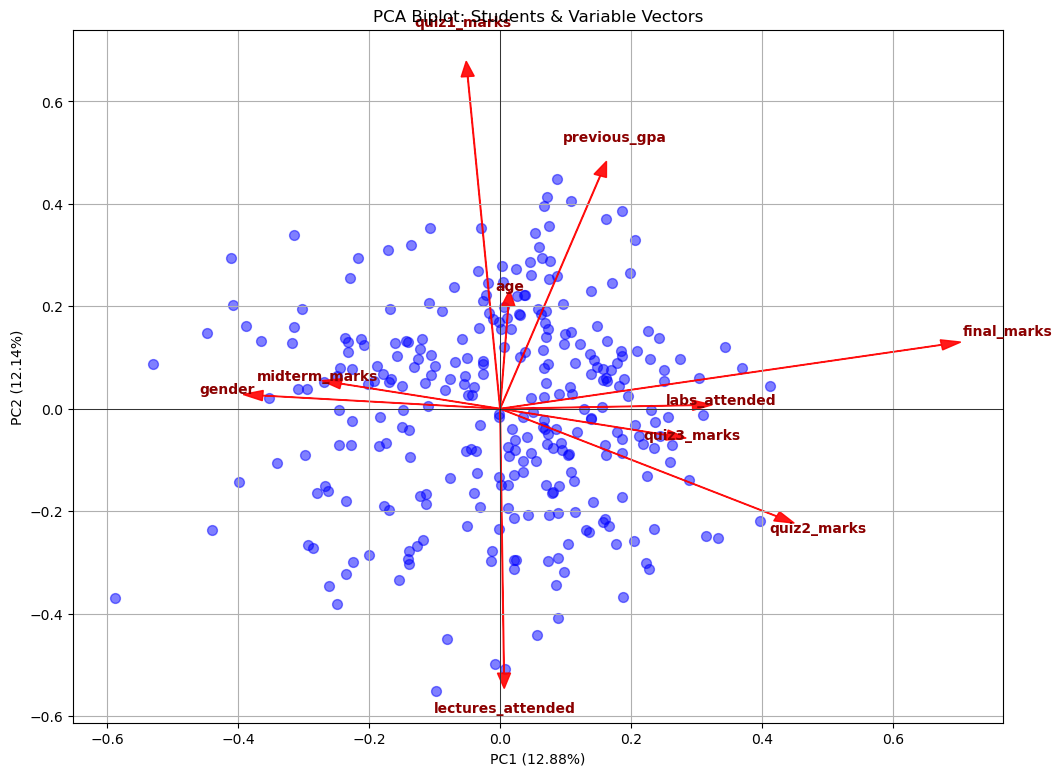

1. PC1 (X-axis): Likely 'Academic Performance'. Arrows pointing Right = High Grades.
2. PC2 (Y-axis): Likely 'Effort vs Ability'. Separates those who attend vs those who just rely on GPA.
3. Long arrows (like 'final_marks') are the most important variables.


In [123]:
# Fit PCA with 2 components
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X_scaled)

# Define Biplot Function
def biplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    plt.figure(figsize=(12, 9))
    plt.scatter(xs * scalex, ys * scaley, c='blue', alpha=0.5, s=50, label='Students')
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.9, head_width=0.02)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var"+str(i+1), color='darkred', ha='center', fontweight='bold')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='darkred', ha='center', fontweight='bold')

    plt.xlabel(f"PC1 ({pca_2.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca_2.explained_variance_ratio_[1]*100:.2f}%)")
    plt.title("PCA Biplot: Students & Variable Vectors")
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)

# Generate Plot
biplot(X_pca, pca_2.components_.T, labels=X_data.columns)
plt.show()

print("1. PC1 (X-axis): Likely 'Academic Performance'. Arrows pointing Right = High Grades.")
print("2. PC2 (Y-axis): Likely 'Effort vs Ability'. Separates those who attend vs those who just rely on GPA.")
print("3. Long arrows (like 'final_marks') are the most important variables.")

<br>

## **Part 4 - Clustering**

c:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Y

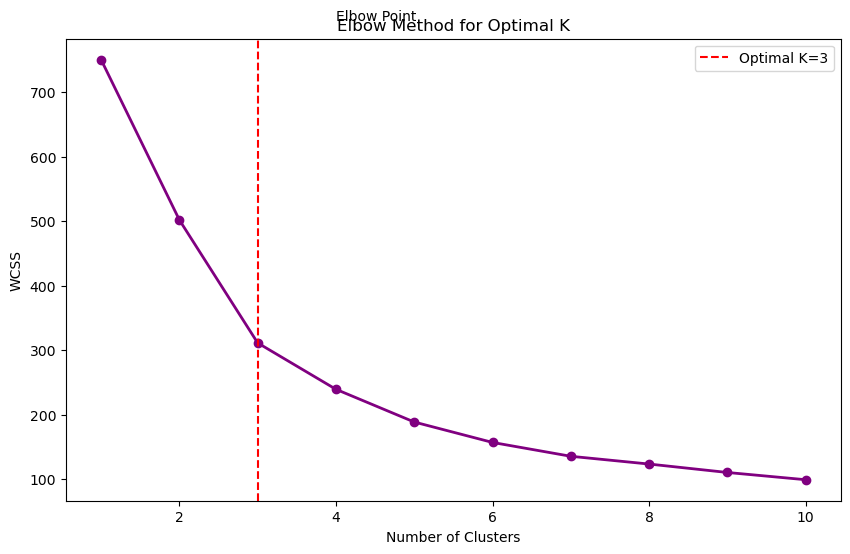

The Elbow occurs at K=3. This is the optimal balance between simplicity and accuracy.


In [124]:
# 1. Calculate WCSS
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# 2. Plot with Highlight
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', color='purple', linewidth=2)

optimal_k = 3 # Assume 3 is optimal
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
plt.annotate('Elbow Point', xy=(optimal_k, wcss[optimal_k-1]), 
             xytext=(optimal_k+1, wcss[optimal_k-1]+500))

plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

print(f"The Elbow occurs at K={optimal_k}. This is the optimal balance between simplicity and accuracy.")

In [125]:
# Apply KMeans
k_final = 3
kmeans_final = KMeans(n_clusters=k_final, random_state=42)
clusters = kmeans_final.fit_predict(X_pca)

df['Cluster'] = clusters
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

score = silhouette_score(X_pca, clusters)
print(f"Silhouette Score for K={k_final}: {score:.4f}")

Silhouette Score for K=3: 0.3689


c:\Conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<br>

## **Part 5 - Cluster Profiling & Educational Recommendations**

CLUSTER 0: At-Risk Students (Need Intervention)
   • Student Count: 111
   • Avg Final Marks: 40.76 / 50
   • Avg GPA:         2.59 / 4.0
   • Avg Attendance:  8.3 sessions
CLUSTER 1: At-Risk Students (Need Intervention)
   • Student Count: 110
   • Avg Final Marks: 42.33 / 50
   • Avg GPA:         3.10 / 4.0
   • Avg Attendance:  3.6 sessions
CLUSTER 2: At-Risk Students (Need Intervention)
   • Student Count: 79
   • Avg Final Marks: 25.73 / 50
   • Avg GPA:         2.70 / 4.0
   • Avg Attendance:  6.1 sessions


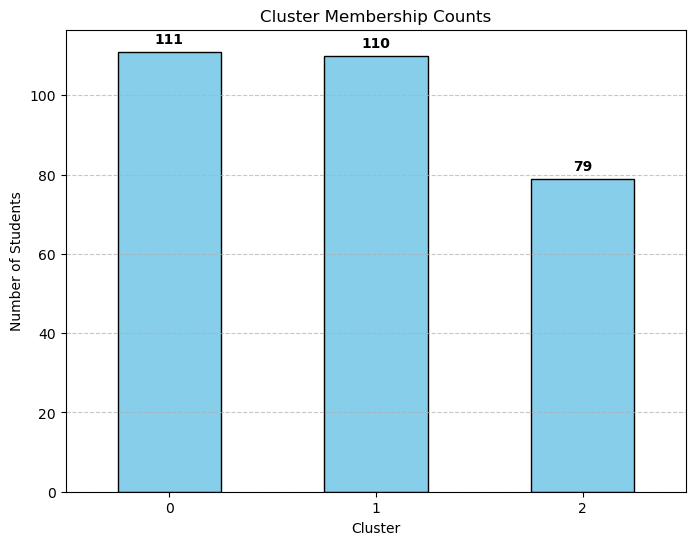

Membership Distribution
1. Look at the bar heights: Are the clusters balanced?
2. If the 'At-Risk' cluster bar is the highest, the course has a high failure rate.
3. Use the counts above to allocate resources (e.g., how many tutors are needed).


In [126]:
# Calculate Mean Stats for each Cluster (for the text report)
cluster_stats = df.groupby('Cluster')[['final_marks', 'previous_gpa', 'lectures_attended']].mean()
cluster_counts = df['Cluster'].value_counts().sort_index()

# Define a function to generate the profile label dynamically
def get_cluster_label(row):
    if row['final_marks'] >= 35 and row['lectures_attended'] >= 15:
        return "High Achievers (Top Performers)"
    elif row['final_marks'] < 25 or row['lectures_attended'] < 10:
        return "At-Risk Students (Need Intervention)"
    else:
        return "Average / Disengaged Students"

# Print the Text Report (Detailed Profiling)
for cluster_id in sorted(cluster_stats.index):
    stats = cluster_stats.loc[cluster_id]
    count = cluster_counts[cluster_id]
    label = get_cluster_label(stats)
    
    print(f"CLUSTER {cluster_id}: {label}")
    print(f"   • Student Count: {count}")
    print(f"   • Avg Final Marks: {stats['final_marks']:.2f} / 50")
    print(f"   • Avg GPA:         {stats['previous_gpa']:.2f} / 4.0")
    print(f"   • Avg Attendance:  {stats['lectures_attended']:.1f} sessions")

# Generate the Bar Chart (Cluster Membership Counts)
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Cluster Membership Counts')
plt.xlabel('Cluster')
plt.ylabel('Number of Students')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0) # Keep labels horizontal

# Add count labels on top of bars
for i, v in enumerate(cluster_counts):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.show()

print("Membership Distribution")
print("1. Look at the bar heights: Are the clusters balanced?")
print("2. If the 'At-Risk' cluster bar is the highest, the course has a high failure rate.")
print("3. Use the counts above to allocate resources (e.g., how many tutors are needed).")

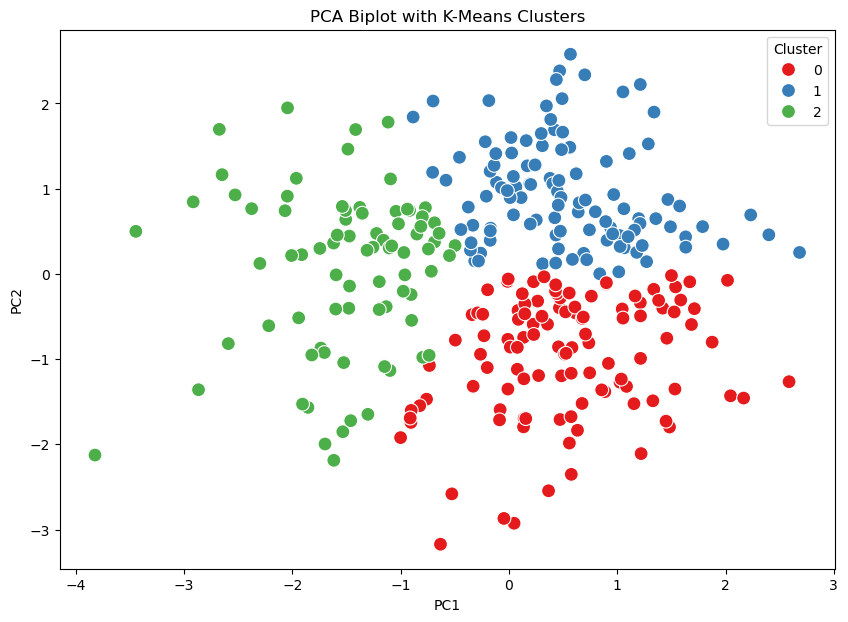

Recommendation for Cluster 0 (At-Risk Students (Need Intervention)):
   1. Early Warning System: SMS alerts if attendance drops below 70%.
   2. Mandatory Counseling: Required advisor meeting to discuss study habits.
   3. Remedial Classes: Extra review sessions before the final exam.


Recommendation for Cluster 1 (At-Risk Students (Need Intervention)):
   1. Early Warning System: SMS alerts if attendance drops below 70%.
   2. Mandatory Counseling: Required advisor meeting to discuss study habits.
   3. Remedial Classes: Extra review sessions before the final exam.


Recommendation for Cluster 2 (At-Risk Students (Need Intervention)):
   1. Early Warning System: SMS alerts if attendance drops below 70%.
   2. Mandatory Counseling: Required advisor meeting to discuss study habits.
   3. Remedial Classes: Extra review sessions before the final exam.




In [127]:
# Overlay clusters on PCA Biplot (Visual Confirmation)
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100)
plt.title(f'PCA Biplot with K-Means Clusters')
plt.legend(title='Cluster')
plt.show()

# Iterate again to print specific advice for each cluster type
for cluster_id in cluster_stats.index:
    stats = cluster_stats.loc[cluster_id]
    label = get_cluster_label(stats)
    
    print(f"Recommendation for Cluster {cluster_id} ({label}):")
    
    if "High Achievers" in label:
        print("   1. Peer Mentoring: Recruit these students as tutors for extra credit.")
        print("   2. Advanced Track: Offer research opportunities with professors.")
        
    elif "At-Risk" in label:
        print("   1. Early Warning System: SMS alerts if attendance drops below 70%.")
        print("   2. Mandatory Counseling: Required advisor meeting to discuss study habits.")
        print("   3. Remedial Classes: Extra review sessions before the final exam.")
        
    else: # Average / Disengaged
        print("   1. Engagement Boost: Introduce gamified quizzes to increase participation.")
        print("   2. Attendance Marks: Increase the grade weight of attendance to 15%.")
    
    print("\n")